##### Версия 0.1 -- Январь 2016

# Источник и сток в безграничном потоке

Вы добрались до второго блокнота курса [*AeroPython*](https://github.com/barbagroup/AeroPython). Готовы? Вы старательно изучили первый блокнот и написали собственную версию питоновского кода для визуализации [Источник и сток](01_Lesson01_sourceSink. ipynb)?

Блокноты составлены таким образом, чтобы продвигаться шаг за шагом, так что не пропускайте ни одного! Изучив каждый, вы углубите свои знания аэродинамики и Python. В этом блокноте мы получим потенциальное течение, сложив источник, сток и равномерный бесконечный поток. Почему? Потому что можем! Помните *суперпозицию*? Это приятное свойство (линейного) потенциального потока, описываемого уравнением Лапласа: $\nabla^2 \phi =0$.

В этом блокноте мы также научимся придавать коду более модульную структуру путем использования функций. Так кодом будет проще управлять.

## Начнем, пожалуй

Начнем, как и в прошлый раз, с импорта библиотек, которыми мы будем пользоваться в блокноте: **NumPy** для работы с массивами, **Matplotlib** для визуализации и `math` для различных математических функций.

Еще добавим команду `%matplotlib inline` для встраивания рисунков в блокнот.

In [1]:
import numpy
import math
from matplotlib import pyplot
# отображение картинок в блокноте
%matplotlib inline

Для визуализации линий тока нам нужно создать расчетную сетку из узлов, в которых будет вычисляться скорость. В прошлом блокноте мы уже это делали, поэтому просто скопируем сюда нужный код. И сразу после копирования и вставки кода, вы можете подумать: *А почему бы не написать функцию, которая будет создавать сетку для любого потока? Тогда я могу повторно использовать ее!* И вы будете абсолютно правы, подумав так. Но давайте сделаем это по-старому.

In [2]:
N = 200                     # Число узлов сетки в каждом направлении
x_start, x_end = -4.0, 4.0            # границы по x
y_start, y_end = -2.0, 2.0            # границы по y
x = numpy.linspace(x_start, x_end, N)    # одномерный массив x
y = numpy.linspace(y_start, y_end, N)    # одномерный массив y
X, Y = numpy.meshgrid(x, y)              # создает сетку

Теперь у нас есть набор точек, и два массива `X` и `Y`, содержащих координаты $x$-и $y$ (соответственно) каждой точки на прямоугольной сетке.

Интересно, насколько хорошо вы понимаете, что делает функция [`meshgrid()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html)? Какой размерности массив `X` и как выглядят его элементы? Вы можете спросить Python о размере массива с помощью функции NumPy `shape()`:

In [3]:
numpy.shape(X)

(200, 200)

Это то, что вы ожидали? Поразмыслите над этим. Убедитесь, что теперь вы понимаете, что происходит.

## Источник в равномерном потоке

В предыдущем блокноте мы уже вычислили поле скоростей источника и стока. Сначала наложим поле от источника на равномерный поток, и посмотрим, что получится.

Линии тока невозмущенного однородного потока со скоростью $U_\infty$ и углом атаки $\alpha$ задаются выражением:

$$\psi_\text{freestream}\left(x,y\right) = U_\infty \left(y\cos\alpha - x\sin\alpha\right)$$

Линии тока представляют собой параллельные прямые, проходящие под углом $\alpha$ к оси $x$. Если поток горизонтальный, то $\psi= U_\infty y$. Продифференцировав, получим $u=U_\infty$ и $v=0$.

Напишем код, в котором в каждой точке расчетной сетки вычисляются компоненты скорости $u$ и $v$ и функция тока $\left(U_\infty,\alpha=0\right)$. Обратите внимание на весьма полезную функцию [`ones()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ones.html), которая создает новый массив и заполняет его единицами, и на не менее полезную функцию `zeros()`, которая делает ... догадайтесь, что?

In [4]:
u_inf = 1.0        # скорость на бесконечности

# вычисляем компоненты скорости равномерного потока
u_freestream = u_inf * numpy.ones((N, N), dtype=float)
v_freestream = numpy.zeros((N, N), dtype=float)

# вычисляем функцию тока
psi_freestream = u_inf * Y

Заметили, как мы одним махом вычислили все значения `psi_freestream`?  Никаких громоздких двойных циклов — и оказывается, когда массивы большие, это еще и  намного быстрее вычисляется! Все благодаря `Numpy`!

Как известно из предыдущего блокнота, функция тока для источника, расположенного в точке $\left(x_\text{source},y_\text{source}\right)$ записывается в виде

$$\psi_\text{source}\left(x,y\right) = \frac{\sigma}{2\pi} \arctan \left(\frac{y-y_\text{source}}{x-x_\text{source}}\right)$$

а компоненты скорости – 

$$u_\text{source}\left(x,y\right) = \frac{\sigma}{2\pi} \frac{x-x_\text{source}}{\left(x-x_\text{source}\right)^2 + \left(y-y_\text{source}\right)^2}$$

$$v_\text{source}\left(x,y\right) = \frac{\sigma}{2\pi} \frac{y-y_\text{source}}{\left(x-x_\text{source}\right)^2 + \left(y-y_\text{source}\right)^2}$$

Вспомним также, что функция тока и поле скорости для источника и стока идентичны, разница лишь в том, что в первом случае интенсивность положительна, а во втором — отрицательна.

Можно написать функцию двойного назначения: при положительной $\sigma$ она будет давать скорости и функцию тока для источника, а при отрицательной — для стока. Ловко придумано?

Определим функцию `get_velocity()`, вычисляющую компоненты скорости $(u,v)$ на сетке (`X`,`Y`) для особенности с заданной интенсивностью `strength`, расположенной в точке  (`xs`,`ys`). Функция определяется при помощи ключевого слова `def`, за которым следует имя функции и список параметов в круглых скобках. Строка должна оканчиваться двоеточием:

In [5]:
def get_velocity(strength, xs, ys, X, Y):
    """
    Returns the velocity field generated by a source/sink.
    
    Parameters
    ----------
    strength: float
        Strength of the source/sink.
    xs: float
        x-coordinate of the source (or sink).
    ys: float
        y-coordinate of the source (or sink).
    X: 2D Numpy array of floats
        x-coordinate of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
    
    Returns
    -------
    u: 2D Numpy array of floats
        x-component of the velocity vector field.
    v: 2D Numpy array of floats
        y-component of the velocity vector field.
    """
    u = strength/(2*numpy.pi)*(X-xs)/((X-xs)**2+(Y-ys)**2)
    v = strength/(2*numpy.pi)*(Y-ys)/((X-xs)**2+(Y-ys)**2)
    
    return u, v

Вы заметили сообщение после определения функции? Оно называется "docstring" и нужно, чтобы пользователь узнал, как работает функция. Любое сообщение в `"""тройных кавычках"""` сразу после определения функции будет отображаться для пользователя при вызове `help()`. Например, так:

In [6]:
help(get_velocity)

Help on function get_velocity in module __main__:

get_velocity(strength, xs, ys, X, Y)
    Returns the velocity field generated by a source/sink.
    
    Parameters
    ----------
    strength: float
        Strength of the source/sink.
    xs: float
        x-coordinate of the source (or sink).
    ys: float
        y-coordinate of the source (or sink).
    X: 2D Numpy array of floats
        x-coordinate of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
    
    Returns
    -------
    u: 2D Numpy array of floats
        x-component of the velocity vector field.
    v: 2D Numpy array of floats
        y-component of the velocity vector field.



Обратите внимание,  что функция возвращает два массива: `u` и `v`. Они вычисляются внутри функции, о чем говорит наличие отступов в строках после двоеточия. Ключевое слово `return` в послендней строке означает, что массивы `u` и `v` возвращаются в выражение, в котором вызывалась функция.

Аналогичным образом мы определим другую функцию для вычисления функции ток для особенности (источника или стока) в узлах сетки и назовем ее `get_stream_function()`.

In [7]:
def get_stream_function(strength, xs, ys, X, Y):
    """
    Returns the stream-function generated by a source/sink.
    
    Parameters
    ----------
    strength: float
        Strength of the source/sink.
    xs: float
        x-coordinate of the source (or sink).
    ys: float
        y-coordinate of the source (or sink).
    X: 2D Numpy array of floats
        x-coordinate of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
    
    Returns
    -------
    psi: 2D Numpy array of floats
        The stream-function.
    """
    psi = strength/(2*numpy.pi)*numpy.arctan2((Y-ys), (X-xs))
    
    return psi

Теперь, используя эти две функции, можно вычислить поле скорости и функцию тока для источника. Теперь доабавить еще одну особенность в поток, например сток, будет проще простого!

Давайте же воспользуемся нашими новенькими функциями:

In [8]:
strength_source = 5.0            # интенсивность источника
x_source, y_source = -1.0, 0.0   # положение источника

# вычисляем поле скоростей
u_source, v_source = get_velocity(strength_source, x_source, y_source,\
                                  X, Y)

# вычисляем функцию тока
psi_source = get_stream_function(strength_source, x_source, y_source,\
                                 X, Y)

Снова применим принцип суперпозиции. Линии тока для комбинации свободного потока и источника:

$$\psi = \psi_{freestream}+\psi_{source} = U_\infty y + \frac{\sigma}{2\pi} \arctan \left(\frac{y-y_\text{source}}{x-x_\text{source}}\right)$$

А поскольку дифференцирование — линейная операция, новое поле скорости является просто суммой соответствующих полей свободного потока и источника:

$$u = u_\text{freestream} + u_\text{source}$$
$$v = v_\text{freestream} + v_\text{source}$$

В точках торможения скорость потока равна нулю. Чтобы найти их, нужно решить уравнения:

$$u = 0 , \quad v = 0$$

Их решение:

$$x_\text{stagnation} = x_\text{source} - \frac{\sigma}{2\pi U_\infty}$$

$$y_\text{stagnation} = y_\text{source}$$

Линия тока, содержащая точку торможения называется *разделительной линией*. Она отделяет набегающий поток от потока, обусловленного источником. Обозначим разделительную линию на картине линий тока красным цветом. Это можно сделать при помощи функции [`contour()`](http://matplotlib.org/api/pyplot_api.html?highlight=contour#matplotlib.pyplot.contour).

Обратите особое внимание, на подробные инструкции, которые мы даем нашей библиотеке для визуализации: поскольку мы хотим поучить картинку, радующую глаз, то указываем цвет, толщину линий и т. д. Всю необходимую информацию можно почерпнуть из [примеров](http://matplotlib.org/examples/pylab_examples/contour_demo.html).

Положение точки торможения обозначим зеленой точкой, используя функцию [`scatter()`](http://matplotlib.org/api/pyplot_api.html?highlight=scatter#matplotlib.pyplot.scatter).

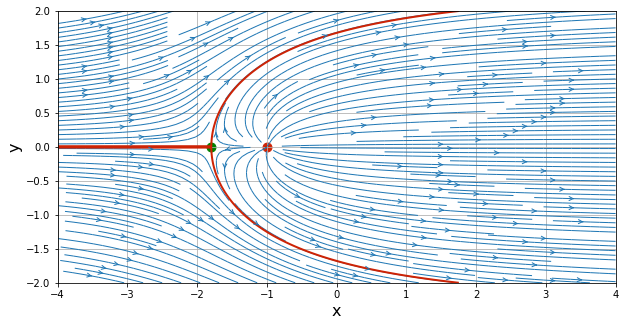

In [9]:
# наложение источника и свободного потока
u = u_freestream + u_source
v = v_freestream + v_source
psi = psi_freestream + psi_source

# рисуем линии тока
size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.streamplot(X, Y, u, v, density=2, linewidth=1, arrowsize=1,\
                  arrowstyle='->')
pyplot.scatter(x_source, y_source, color='#CD2305', s=80, marker='o')

# определяем точку торможения
x_stagnation = x_source - strength_source/(2*numpy.pi*u_inf)
y_stagnation = y_source

# рисуем точку торможения
pyplot.scatter(x_stagnation, y_stagnation, color='g', s=80, marker='o')

# рисуем разделительную линию тока
pyplot.contour(X, Y, psi, 
            levels=[-strength_source/2, +strength_source/2], 
            colors='#CD2305', linewidths=2, linestyles='solid');

Как по-вашему, на что это похоже? Выделенная таким прямолинейными образом разделительная линия создает впечатление, что набегающий слева поток раздваивается, чтобы обтечь препятствие криволинейной формы, похожее, например, на переднюю кромку профиля.

Если не обращать внимание на поток *внутри* области, ограниченной разделительной линией, ее можно считать твердым телом. С математической точки зрения, разделительную линию тока можно заменить твердой стенкой, так как на линии тока выполняется условие непротекания. На самом деле, в случае источника в равномерном потоке, у такого тела есть собственное название — *полубесконечное тело Рэнкина*.

##### Контрольный вопрос

Какова максимальная *ширина* полубесконечного тела Рэнкина.

**Подсказка** Используйте закон сохранения массы и рассмотрите случай, когда $x$ стремится к бесконечности.

## Система источник-сток в равномерном потоке

Как вы думаете, что получится, если имеющейся картине добавить сток? Давайте выясним это! Сейчас мы можем в полной мере оценить пользу функций `getVelocity()` и `getStreamfunction()`, позволяющих создать без особых усилий.

In [10]:
strength_sink = -5.0        # интенсивность стока
x_sink, y_sink = 1.0, 0.0   # положение стока

# вычисляем поле скорости в каждой точке сетки
u_sink, v_sink = get_velocity(strength_sink, x_sink, y_sink, X, Y)

# вычисляем функцию тока в каждом узле расчетной сетки
psi_sink = get_stream_function(strength_sink, x_sink, y_sink, X, Y)

Суперпозиция свободного потока, источника и стока производится простым сложением. Заметьте, как лихо мы сложили элементы двумерных массивов. Одно удовольствие.

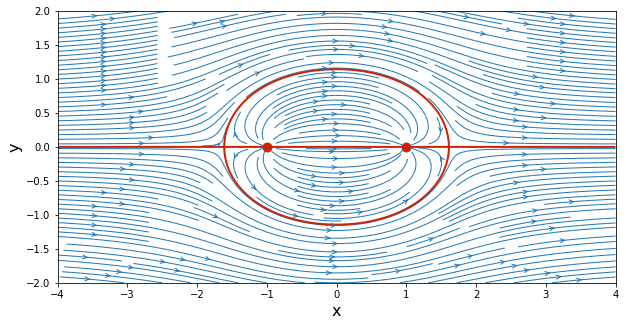

In [11]:
# суперпозиция свободного потока, источника и стока
u = u_freestream + u_source + u_sink
v = v_freestream + v_source + v_sink
psi = psi_freestream + psi_source + psi_sink

# рисуем линии тока
size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.streamplot(X, Y, u, v, density=2, linewidth=1, arrowsize=1,\
                  arrowstyle='->')
pyplot.scatter([x_source, x_sink], [y_source, y_sink], color='#CD2305',\
               s=80, marker='o')
pyplot.contour(X, Y, psi, levels=[0.], colors='#CD2305', linewidths=2,\
               linestyles='solid');

Результат выглядит *весьма* интересно. Поток как будто обтекает яйцо, похоже? На самом деле, замкнутую линию тока, похожую на эллипс, можно рассматривать как твердое тело, и тогда получается, что поток обтекает что-то яйцеобразное. Оно называется *овал Рэнкина* (от лат. *ovum* — яйцо).

Можете поэкспериментировать с интенсивностью источника и стока и посмотреть, как изменится картина течния. Не забудьте также написать собственную версию кода в отдельном питоновском скрипте и запустить его с различными параметрами.

##### Контрольный вопрос

Чему равны длина и ширина овала Рэнкина?

### Уравнение Бернулли и коэффициент давления

Крайне важной характеристикой обтекания тела потоком является *коэффициент давления* $C_p$. Для оценки коэффициента давления применим *уравнение Бернулли* для несжимаемого течения:

$$p_\infty + \frac{1}{2}\rho V_\infty^2 = p + \frac{1}{2}\rho V^2$$

Помните ли вы условия, при которых выводится это уравнение? Если кто-то забыл, напомню, оно справедливо *вдоль линии тока*. Это очень важно.

Коэффициент давления определяется следующим образом:

$$C_p = \frac{p-p_\infty}{\frac{1}{2}\rho V_\infty^2}$$

то есть

$$C_p = 1 - \left(\frac{V}{V_\infty}\right)^2$$

Обратите внимание, для несжимаемого течения в точке торможения $C_p=1$.

Теперь нарисуем поле коэффициента давления для рассматриваемого течения. Подумайте и ответьте: Где находится максимум давления? Почему?

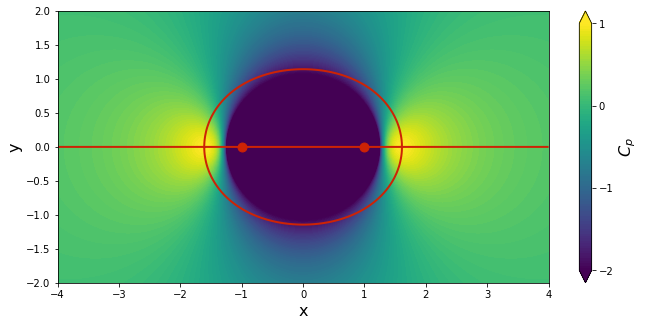

In [12]:
# вычисляем поле коэффициента давления
cp = 1.0 - (u**2+v**2)/u_inf**2

# рисуем поле коэффициента давления
size = 10
pyplot.figure(figsize=(1.1*size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
contf = pyplot.contourf(X, Y, cp, levels=numpy.linspace(-2.0, 1.0, 100),\
                        extend='both')
cbar = pyplot.colorbar(contf)
cbar.set_label('$C_p$', fontsize=16)
cbar.set_ticks([-2.0, -1.0, 0.0, 1.0])
pyplot.scatter([x_source, x_sink], [y_source, y_sink], color='#CD2305',\
               s=80, marker='o')
pyplot.contour(X, Y, psi, levels=[0.], colors='#CD2305', linewidths=2,\
               linestyles='solid');

---

## Заключительные замечания

Изучите материал, изложенный в этом блокноте и попробуйте "подергать за ниточки" прямо в нем. Но в то же время начните писать собственную версию кода в удобном для вас редакторе — и, пожалуйста, *набирайте * код вместо копирования и вставки. При таком способе работы у вас появится время, чтобы подумать о том, что код означает.

На третьем занятии курса *AeroPython* вы познакомитесь с [*диполем*](03_Lesson03_doublet.ipynb). Вперед, к свершениям!

---

In [13]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()